## Description

This notebook aims providing an EDA (exploratory data analysis) of the covid-19 dataset from Hospital Israelita Albert Einstein.
The notebook is splited in the following sections:

* **Importings:** Importing libs and data
* **Analysis:** Analysing data, dropping unnecessary columns, treating null values, checking features
* **Feature Importance:** Identifying important features by applying decision tree
* **Modeling:** Applying classification models (logistic regression, knn, decision tree, random forest, adaboost, svm) combined with samplers (random under sampler and random over sampler), and xgboost to identify covid-19
* **Conclusion:** Results in the test dataset (f1-score, recall, accuracy)

### Importings

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_excel('dataset.xlsx')

### Analysis

In [6]:
df.shape

(5644, 111)

The dataset is very unbalanced (covid-19 is only present in 90% of the data), so I will consider this during modeling.

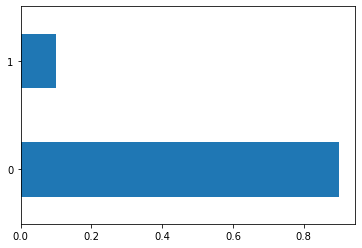

In [111]:
df['SARS-Cov-2 exam result'].value_counts(True).plot.barh()

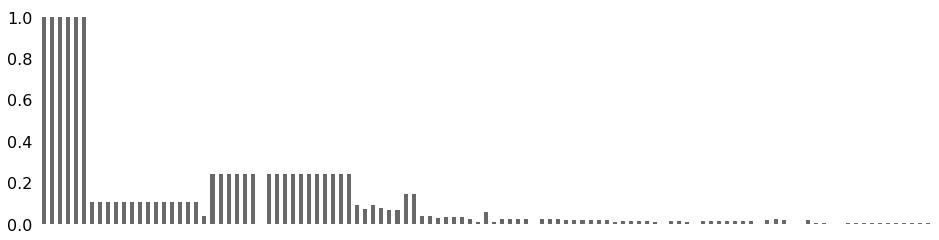

In [5]:
# checking null values
msno.bar(df, figsize=(16, 4))

It seems that there are some columns with all values equal null, so I'll drop them.

In [7]:
(df.isnull().sum() == df.shape[0]).any()

True

In [8]:
full_null_series = (df.isnull().sum() == df.shape[0])
full_null_columns = full_null_series[full_null_series == True].index

In [9]:
# columns with all values equal null
print(full_null_columns.tolist())

['Mycoplasma pneumoniae', 'Urine - Sugar', 'Partial thromboplastin time\xa0(PTT)\xa0', 'Prothrombin time (PT), Activity', 'D-Dimer']


In [10]:
df.drop(full_null_columns, axis=1, inplace=True)

We still have many values null in the dataset.
I'll drop the columns that only have one value in the target, since they'll hardly help to discriminate the presence of Covid-19.

In [11]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False).head()

Fio2 (venous blood gas analysis)    0.999823
Urine - Nitrite                     0.999823
Vitamin B12                         0.999468
Lipase dosage                       0.998583
Albumin                             0.997697
dtype: float64

In [12]:
contain_null_series = (df.isnull().sum() != 0).index

In [13]:
target = 'SARS-Cov-2 exam result'
just_one_target = []

for col in contain_null_series:
    i = df[df[col].notnull()][target].nunique()
    if i == 1:
        just_one_target.append(col)    

# columns that only are present when covid is negative        
print(just_one_target)

['Fio2 (venous blood gas analysis)', 'Urine - Nitrite', 'Vitamin B12', 'Albumin']


In [14]:
for col in just_one_target:
    print(df[df[col].notnull()][target].unique())

['negative']
['negative']
['negative']
['negative']


In [15]:
df.drop(just_one_target, axis=1, inplace=True)

We still have many null values in the dataset.
I'll plot the columns that doesn't have any null to check if they can discriminate the target.

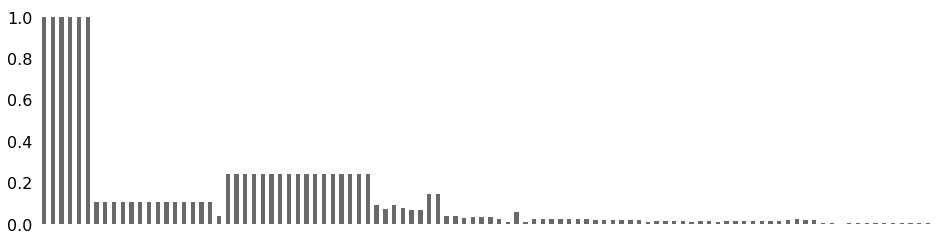

In [15]:
msno.bar(df, figsize=(16, 4))

In [16]:
not_null_series = (df.isnull().sum() == 0)
not_null_columns = not_null_series[not_null_series == True].index
not_null_columns = not_null_columns[1:]

<Figure size 432x288 with 0 Axes>

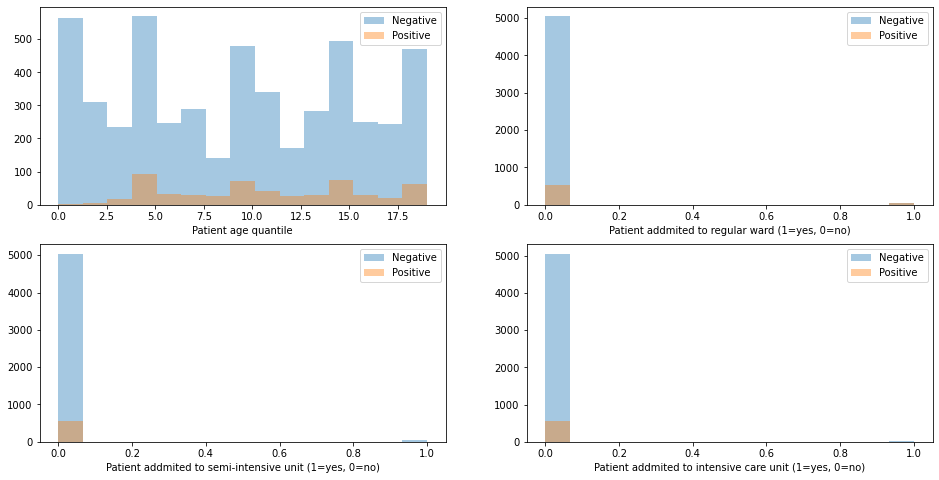

In [17]:
def plot_histograms(df, cols, subplots_rows, subplots_cols, figsize=(16, 8), target='SARS-Cov-2 exam result'):
    df_neg = df[df[target] == 'negative']
    df_pos = df[df[target] == 'positive']
    
    cols = cols.tolist()
    cols.remove(target)
    
    plt.figure()
    fig, ax = plt.subplots(subplots_rows, subplots_cols, figsize=figsize)
    
    i = 0    
    for col in cols:
        i += 1
        plt.subplot(subplots_rows, subplots_cols, i)
        sns.distplot(df_neg[col], label="Negative", bins=15, kde=False)
        sns.distplot(df_pos[col], label="Positive", bins=15, kde=False)
        plt.legend()
    plt.show()
    
plot_histograms(df, not_null_columns, 2, 2)

It's hard to see any feature that can help determine presence of covid-19.
I'll prepare the data do convert categorical features to numeric and examine the feature importance of the features with logistic regression and decision tree models

In [17]:
# dataprep categorical
mask_pos_neg = {'positive': 1, 'negative': 0}
mask_detected = {'detected': 1, 'not_detected': 0}
mask_notdone_absent_present = {'not_done': 0, 'absent': 1, 'present': 2}
mask_normal = {'normal': 1}
mask_urine_color = {'light_yellow': 1, 'yellow': 2, 'citrus_yellow': 3, 'orange': 4}
mask_urine_aspect = {'clear': 1, 'lightly_cloudy': 2, 'cloudy': 3, 'altered_coloring': 4}
mask_realizado = {'Não Realizado': 0}
mask_urine_leuk = {'<1000': 1000}
mask_urine_crys = {'Ausentes': 1, 'Urato Amorfo --+': 0, 'Oxalato de Cálcio +++': 0,
                   'Oxalato de Cálcio -++': 0, 'Urato Amorfo +++': 0}

In [18]:
df = df.replace(mask_detected)
df = df.replace(mask_pos_neg)
df = df.replace(mask_notdone_absent_present)
df = df.replace(mask_normal)
df = df.replace(mask_realizado)
df = df.replace(mask_urine_leuk)
df = df.replace(mask_urine_color)
df = df.replace(mask_urine_aspect)
df = df.replace(mask_urine_crys)

df['Urine - pH'] = df['Urine - pH'].astype('float')
df['Urine - Leukocytes'] = df['Urine - Leukocytes'].astype('float')

In [19]:
x = df.drop(['Patient ID', 'SARS-Cov-2 exam result'], axis=1)
x.fillna(999999, inplace=True)
y = df['SARS-Cov-2 exam result']

### Feature importances

Now I'll check the most important features according to decision tree.
This information can bring insights by applying feature engineering to improve the classification of the target.

In [24]:
dt = DecisionTreeClassifier(max_depth=3)

In [31]:
dt.fit(x, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

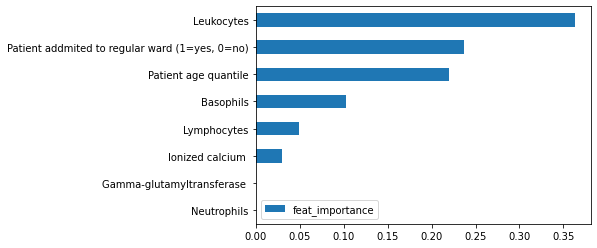

In [32]:
dt_feat = pd.DataFrame(dt.feature_importances_, index=x.columns, columns=['feat_importance'])
dt_feat.sort_values('feat_importance').tail(8).plot.barh()
plt.show()

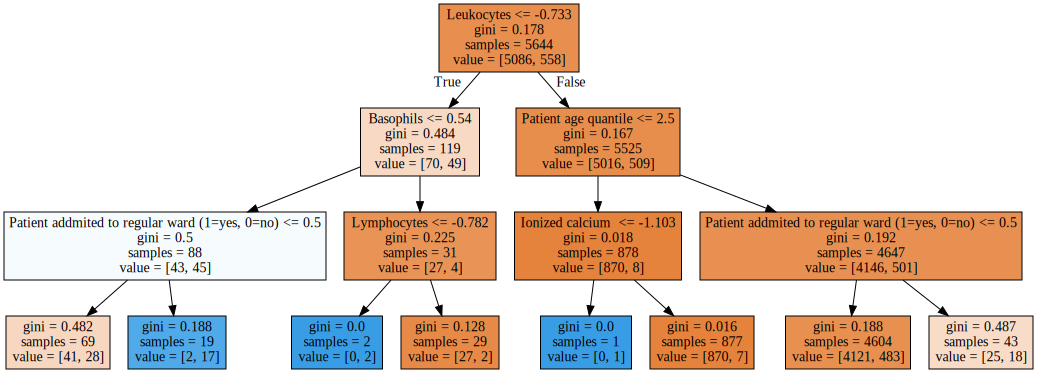

In [148]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

graph = Source(export_graphviz(dt, out_file=None, feature_names=x.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

By looking at the `Leukocytes`, it seems that the feature helps to discriminate the data indeed

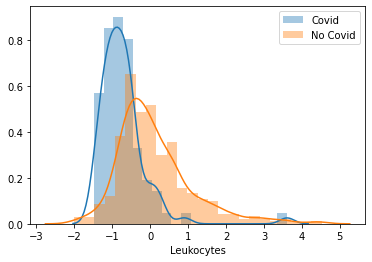

In [118]:
sns.distplot(df[df['SARS-Cov-2 exam result'] == 1]['Leukocytes'], label="Covid")
sns.distplot(df[df['SARS-Cov-2 exam result'] == 0]['Leukocytes'], label="No Covid")
plt.legend()

### Modeling

I will try to identify covid-19 by applying several models combined with random over sampler and random under sampler. The samplers will balance the dataset, so it should reduce the bias of my models. I will also apply xgboost with hyperparameter tuning.

In [34]:
classifiers = {'Logistic Regression' : LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'AdaBoost': AdaBoostClassifier(),
               'SVM': SVC()}

samplers = {'Random_under_sampler': RandomUnderSampler(),
            'Random_over_sampler': RandomOverSampler()}

In [35]:
drop_cols = ['Patient ID', 'Patient addmited to regular ward (1=yes, 0=no)',
             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
             'Patient addmited to intensive care unit (1=yes, 0=no)']

In [36]:
def df_split(df, target='SARS-Cov-2 exam result', drop_cols=drop_cols):
    df = df.drop(drop_cols, axis=1)
    df = df.fillna(999)
    x = df.drop(target, axis=1)
    y = df[target]    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)                          
    return x_train, x_test, y_train, y_test

In [37]:
def train_clfs(df, classifiers, samplers):
    
    x_train, x_test, y_train, y_test = df_split(df)
    
    names_samplers = []
    names_clfs = []
    results_train_cv_f1 = []
    results_train_cv_recall = []
    results_train_cv_accuracy = []
    results_test_f1 = []
    results_test_recall = []
    results_test_accuracy = []
    
    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}\n')
        for name_clf, clf in classifiers.items():
            print(f'Classifier: {name_clf}\n')
            
            pipeline = Pipeline([('sampler', sampler),
                                 ('clf', clf)])
            
            cv_f1 = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='f1') 
            cv_rec = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='recall')                                
            cv_acc = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='accuracy')        

            pipeline.fit(x_train, y_train)        
            y_pred = pipeline.predict(x_test)
            
            names_samplers.append(name_sampler)
            names_clfs.append(name_clf)
            results_train_cv_f1.append(cv_f1)
            results_train_cv_recall.append(cv_rec)
            results_train_cv_accuracy.append(cv_acc)
            results_test_f1.append(f1_score(y_test, y_pred))
            results_test_recall.append(recall_score(y_test, y_pred))
            results_test_accuracy.append(accuracy_score(y_test, y_pred))

            print(f'CV\t-\tf1-score:\t{round(cv_f1.mean(), 3)}')
            print(f'CV\t-\trecall:\t\t{round(cv_rec.mean(), 3)}')
            print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')

            print(f'Test\t-\tf1-score:\t{round(f1_score(y_test, y_pred), 3)}')         
            print(f'Test\t-\trecall:\t\t{round(recall_score(y_test, y_pred), 3)}')          
            print(f'Test\t-\taccuracy:\t{round(accuracy_score(y_test, y_pred), 3)}')      
            print('\n<-------------------------->\n')

    df_results_test = pd.DataFrame(index=[names_clfs, names_samplers], columns=['F1_SCORE', 'RECALL', 'ACCURACY'])
    df_results_test['F1_SCORE'] = results_test_f1
    df_results_test['RECALL'] = results_test_recall
    df_results_test['ACCURACY'] = results_test_accuracy

    return df_results_test

In [38]:
df_results_test = train_clfs(df, classifiers, samplers)

Sampler: Random_under_sampler

Classifier: Logistic Regression

CV	-	f1-score:	0.19
CV	-	recall:		0.763
CV	-	accuracy:	0.368
Test	-	f1-score:	0.193
Test	-	recall:		0.768
Test	-	accuracy:	0.363

<-------------------------->

Classifier: KNN

CV	-	f1-score:	0.109
CV	-	recall:		0.146
CV	-	accuracy:	0.804
Test	-	f1-score:	0.154
Test	-	recall:		0.161
Test	-	accuracy:	0.825

<-------------------------->

Classifier: Decision Tree

CV	-	f1-score:	0.212
CV	-	recall:		0.614
CV	-	accuracy:	0.52
Test	-	f1-score:	0.233
Test	-	recall:		0.848
Test	-	accuracy:	0.447

<-------------------------->

Classifier: Random Forest

CV	-	f1-score:	0.221
CV	-	recall:		0.675
CV	-	accuracy:	0.524
Test	-	f1-score:	0.239
Test	-	recall:		0.777
Test	-	accuracy:	0.51

<-------------------------->

Classifier: AdaBoost

CV	-	f1-score:	0.217
CV	-	recall:		0.756
CV	-	accuracy:	0.48
Test	-	f1-score:	0.234
Test	-	recall:		0.795
Test	-	accuracy:	0.483

<-------------------------->

Classifier: SVM

CV	-	f1-score:	0.187
CV	-

In [51]:
def train_xgb(df, clf):
    
    x_train, x_test, y_train, y_test = df_split(df)

    scale_pos_weight = len(df[df['SARS-Cov-2 exam result'] == 0]) / len(df[df['SARS-Cov-2 exam result'] == 1])

    param_grid = {'xgb__max_depth': [3, 4, 5, 6, 7, 8],
                  'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'xgb__colsample_bytree': [0.6, 0.7, 0.8],
                  'xgb__min_child_weight': [0.4, 0.5, 0.6],
                  'xgb__gamma': [0, 0.01, 0.1],
                  'xgb__reg_lambda': [6, 7, 8, 9, 10],
                  'xgb__n_estimators': [150, 200, 300],
                  'xgb__scale_pos_weight': [scale_pos_weight]}

    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=100,
                                n_jobs=-1, verbose=2, cv=5,                            
                                scoring='f1', random_state=42)

    rs_clf.fit(x_train, y_train)
    
    print(f'XGBOOST BEST PARAMS: {rs_clf.best_params_}')
    
    y_pred = rs_clf.predict(x_test)

    df_results_xgb = pd.DataFrame(index=[['XGBoost'], ['No_sampler']], columns=['F1_SCORE', 'RECALL', 'ACCURACY'])

    df_results_xgb['F1_SCORE'] = f1_score(y_test, y_pred)
    df_results_xgb['RECALL'] = recall_score(y_test, y_pred)
    df_results_xgb['ACCURACY'] = accuracy_score(y_test, y_pred)
    
    return df_results_xgb

In [52]:
df_results_xgb = train_xgb(df, xgb.XGBClassifier())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.5min finished


XGBOOST BEST PARAMS: {'xgb__scale_pos_weight': 9.114695340501791, 'xgb__reg_lambda': 7, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 0.5, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.6}


In [53]:
df_results = pd.concat([df_results_test, df_results_xgb])

### Conclusion

We can check the top 9 pipelines for each metric F1-SCORE, RECALL, and ACCURACY in the test dataset below:

In [57]:
df_plot = pd.concat([df_results.sort_values('F1_SCORE', ascending=False).head(3),
                     df_results.sort_values('RECALL', ascending=False).head(3),
                     df_results.sort_values('ACCURACY', ascending=False).head(3)])

In [58]:
def plot_test(df, xlim_min, xlim_max):

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))

    color = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'navy', 'turquoise', 'darkorange']

    df['F1_SCORE'].plot(kind='barh', ax=ax1, xlim=(xlim_min, xlim_max), title='F1_SCORE', color=color)
    df['RECALL'].plot(kind='barh', ax=ax2, xlim=(xlim_min, xlim_max), title='RECALL', color=color)
    df['ACCURACY'].plot(kind='barh', ax=ax3, xlim=(xlim_min, xlim_max), title='ACCURACY', color=color)
    plt.show()

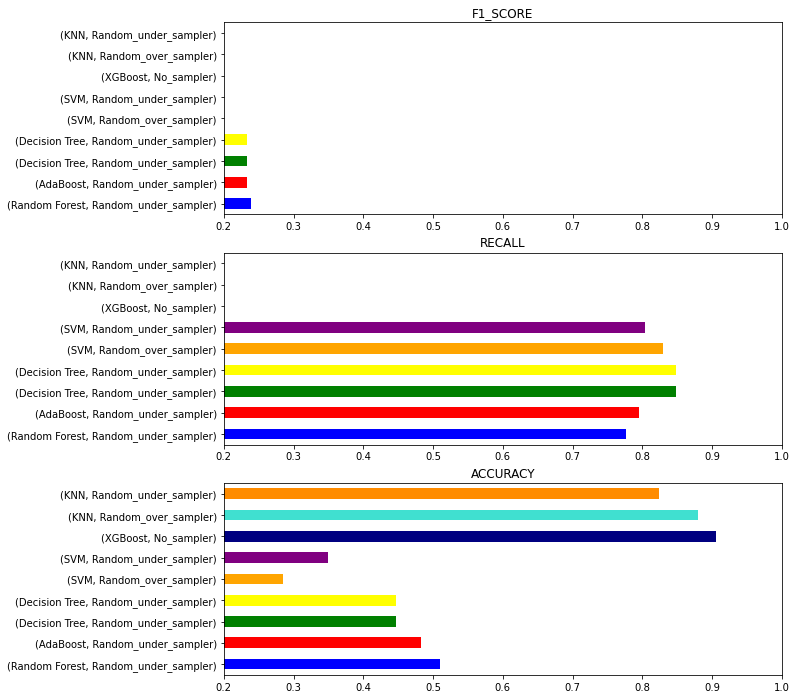

In [59]:
plot_test(df_plot, 0.2, 1)

As we can see, many models performed well according to RECALL, but did not provided good results for ACCURACY.
The choice of the best metric depends on the costs associated to each true or false prediction

<table>
    <th> </th>
    <th style=" border: 1px solid black">Predicted No Covid</th>
    <th style=" border: 1px solid black">Predicted Covid</th>
    <tr style=" border: 1px solid black">
        <td style=" border: 1px solid black"><b>No Covid</b></td>
        <td style=" border: 1px solid black">True Negative</td>
        <td style=" border: 1px solid black">False Positive</td>
    </tr>
    <tr style=" border: 1px solid black">
        <td style=" border: 1px solid black"><b>Covid</b></td>
        <td style=" border: 1px solid black">False Negative</td>
        <td style=" border: 1px solid black">True Positive</td>
    </tr>
</table>

To understand the costs of each value, we can interpret the values of each cell in the confusion matrix as:
- **True Negative:** Model predicted that patient is not infected by covid-19, and he is not. 

**Cost**: Low:- The patient will not need special treatment nor medicaments.

- **False Positive:** Model predicted that patient is infected by covid-19, and he is not.

**Cost**: Medium - The patient will receive special treatment and medicaments unnecessarily.

- **False Negative:**

**Cost**: Very-high - The patient may probably leave the hospital and transmit coronavirus to their colleagues and family, besides risking his life

- **True Positive:**

**Cost**: Medium - The patient will receive special treatment and medicaments.

As we can minimize the risk of false negatives, we should try to choose the models that have high recall. I plotted the confusion matrix of the pipelines `Adaboost + Random Under Sampler` and `Random Forest + Random Under Sampler` for each threshold.

In [47]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['No Covid', 'Covid']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_clf_threshold(df, clf, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_test, y_train, y_test = df_split(df)
    
    if sampler:
        clf_train = Pipeline([('sampler', sampler),
                              ('clf', clf)])
        
    else:        
        clf_train = clf
            
    clf_train.fit(x_train, y_train)
    y_proba = clf_train.predict_proba(x_test)
    
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        y_pred = y_proba[:,1] > i

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test,y_pred)
        np.set_printoptions(precision=2)

        print(f"Threshold: {round(i, 1)} | Test Accuracy: {round(accuracy_score(y_test, y_pred), 2)}| Test Recall: {round(recall_score(y_test, y_pred), 2)} | Test F1 score: {round(f1_score(y_test, y_pred), 2)}")

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_test, y_pred, title=f'Threshold >= {round(i, 1)}')

Threshold: 0.1 | Test Accuracy: 0.28| Test Recall: 0.96 | Test F1 score: 0.21
Threshold: 0.2 | Test Accuracy: 0.32| Test Recall: 0.95 | Test F1 score: 0.22
Threshold: 0.3 | Test Accuracy: 0.35| Test Recall: 0.93 | Test F1 score: 0.22
Threshold: 0.4 | Test Accuracy: 0.37| Test Recall: 0.9 | Test F1 score: 0.22
Threshold: 0.5 | Test Accuracy: 0.46| Test Recall: 0.79 | Test F1 score: 0.23
Threshold: 0.6 | Test Accuracy: 0.74| Test Recall: 0.3 | Test F1 score: 0.19
Threshold: 0.7 | Test Accuracy: 0.83| Test Recall: 0.16 | Test F1 score: 0.15
Threshold: 0.8 | Test Accuracy: 0.84| Test Recall: 0.16 | Test F1 score: 0.17
Threshold: 0.9 | Test Accuracy: 0.84| Test Recall: 0.16 | Test F1 score: 0.17


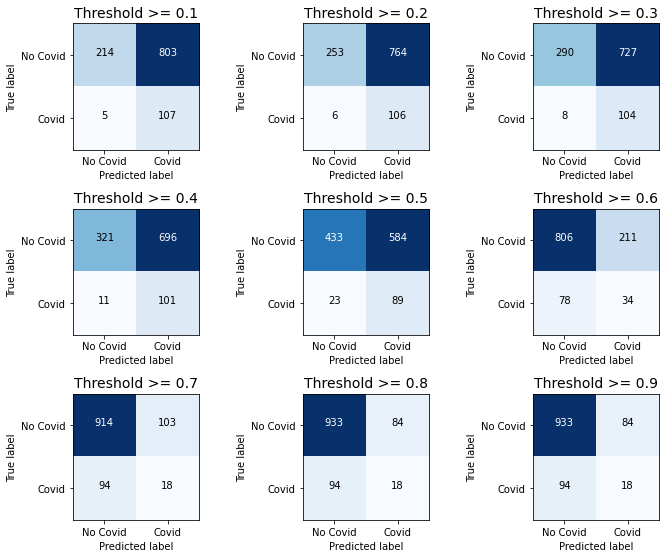

In [48]:
train_clf_threshold(df, DecisionTreeClassifier(), sampler=RandomUnderSampler())

Threshold: 0.1 | Test Accuracy: 0.1| Test Recall: 1.0 | Test F1 score: 0.18
Threshold: 0.2 | Test Accuracy: 0.1| Test Recall: 1.0 | Test F1 score: 0.18
Threshold: 0.3 | Test Accuracy: 0.1| Test Recall: 1.0 | Test F1 score: 0.18
Threshold: 0.4 | Test Accuracy: 0.1| Test Recall: 1.0 | Test F1 score: 0.18
Threshold: 0.5 | Test Accuracy: 0.54| Test Recall: 0.68 | Test F1 score: 0.23
Threshold: 0.6 | Test Accuracy: 0.9| Test Recall: 0.0 | Test F1 score: 0.0
Threshold: 0.7 | Test Accuracy: 0.9| Test Recall: 0.0 | Test F1 score: 0.0
Threshold: 0.8 | Test Accuracy: 0.9| Test Recall: 0.0 | Test F1 score: 0.0
Threshold: 0.9 | Test Accuracy: 0.9| Test Recall: 0.0 | Test F1 score: 0.0


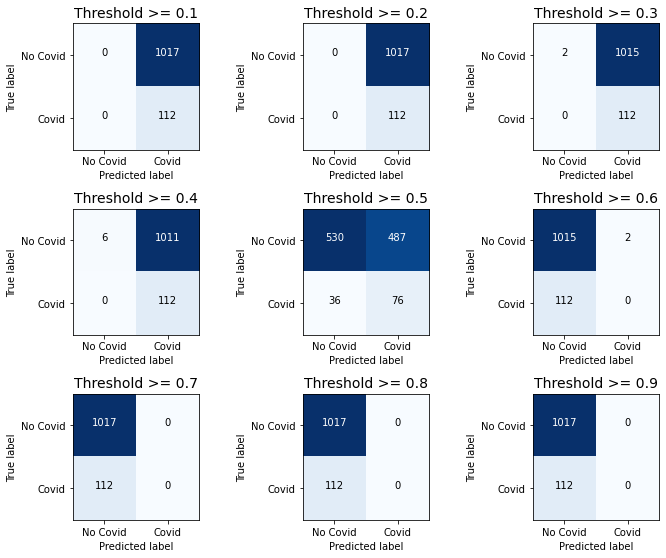

In [49]:
train_clf_threshold(df, AdaBoostClassifier(), sampler=RandomUnderSampler())

Threshold: 0.1 | Test Accuracy: 0.24| Test Recall: 0.99 | Test F1 score: 0.21
Threshold: 0.2 | Test Accuracy: 0.27| Test Recall: 0.99 | Test F1 score: 0.21
Threshold: 0.3 | Test Accuracy: 0.33| Test Recall: 0.93 | Test F1 score: 0.22
Threshold: 0.4 | Test Accuracy: 0.36| Test Recall: 0.91 | Test F1 score: 0.22
Threshold: 0.5 | Test Accuracy: 0.53| Test Recall: 0.73 | Test F1 score: 0.23
Threshold: 0.6 | Test Accuracy: 0.7| Test Recall: 0.41 | Test F1 score: 0.21
Threshold: 0.7 | Test Accuracy: 0.84| Test Recall: 0.17 | Test F1 score: 0.18
Threshold: 0.8 | Test Accuracy: 0.88| Test Recall: 0.03 | Test F1 score: 0.04
Threshold: 0.9 | Test Accuracy: 0.89| Test Recall: 0.02 | Test F1 score: 0.03


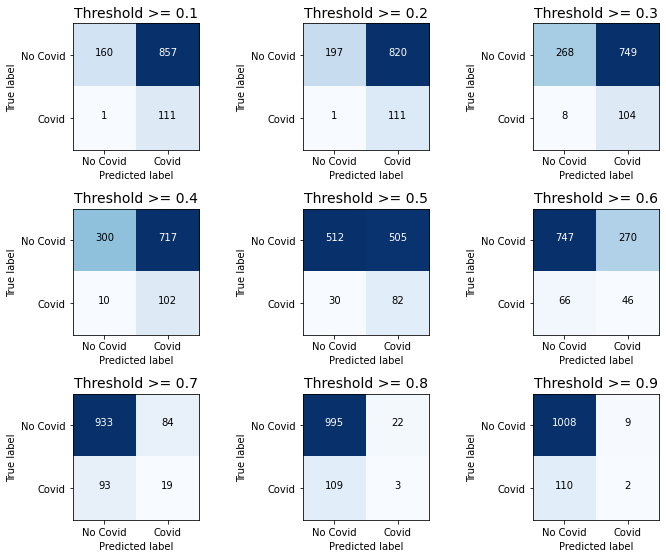

In [50]:
train_clf_threshold(df, RandomForestClassifier(), sampler=RandomUnderSampler())

As we can see, depending on the risk that we want to take, we can choose a model that provide both a high recall and a fair f1-score.